In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

Only enforced parameter at query-level is that redshift "=null"

In [256]:
dat = Table.read('Query090822.fits')
targets = dat.to_pandas()

# Remove trailing whitespace
targets = targets.rename(columns=lambda x: x.strip().lower())

targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 107 entries, name to gbm_cat_fluence_error
dtypes: float64(101), int16(2), object(4)
memory usage: 153.4+ KB


In [260]:
# Apply the flux_ratio calculations
targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                              targets['like_lat_flux'],
                                              targets['like_gbm_flux_error'],
                                              targets['like_lat_flux_error'])

targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                  targets['like_lat_flux_ene'],
                                                  targets['like_gbm_flux_ene_error'],
                                                  targets['like_lat_flux_ene_error'])

targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                  targets['like_lat_fluence'],
                                                  targets['like_gbm_fluence_error'],
                                                  targets['like_lat_fluence_error'])

targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 113 entries, name to fluence_ratio_error
dtypes: float64(107), int16(2), object(4)
memory usage: 162.1+ KB


There should be a negative correlation between burst duration and corresponding flux ratio (0927-6505(96)00018-7, Figure 2.)

### TODO: Do this with fluence, not just flux

Text(0.15, 0.15, 'Fluence ratio ~ hardness wrt. GBM and LAT\nGBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')

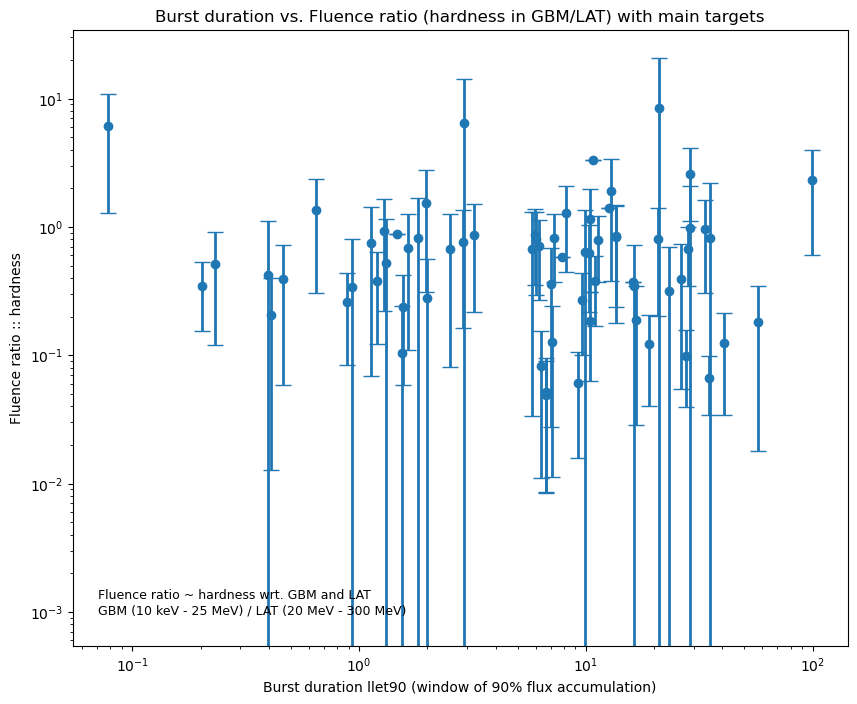

In [263]:
fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration llet90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio :: hardness')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
ax.set_xscale('log')
ax.set_yscale('log')

plt.figtext(0.15, 0.15, 
            'Fluence ratio ~ hardness wrt. GBM and LAT\nGBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
            horizontalalignment='left', fontsize=9)

In [264]:
fig.savefig('Burst_duration_vs_hardness.png')

-------

In [224]:
# Try and see if the correlation exists

# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf flux ratio'% len(targets.loc[targets['flux_ratio'] == np.inf]) )
targets = targets.loc[ targets['flux_ratio'] != np.inf ]
print('Dropping %s targets for NaN flux ratio'% len(targets.loc[ np.isnan(targets['flux_ratio']) ]) )
targets = targets.loc[ ~np.isnan(targets['flux_ratio']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN flux ratio error'% len(targets.loc[ np.isnan(targets['flux_ratio_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['flux_ratio_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. flux ratio error'%len(targets[targets['flux_ratio_error'] ==0]))
targets = targets[targets['flux_ratio_error'] !=0]

Dropping 0 targets for inf flux ratio
Dropping 0 targets for NaN flux ratio
Dropping 0 targets for NaN flux ratio error
Dropping 0 targets for 0. flux ratio error


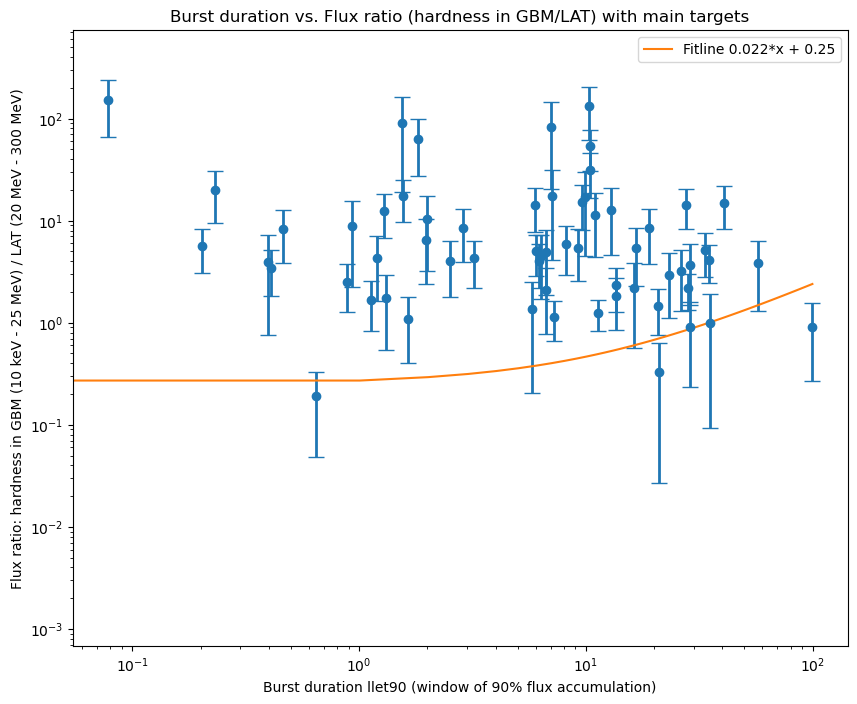

In [212]:
fit = np.polyfit(x = targets['lle_t90'], y = targets['flux_ratio'], 
                 deg = 1, w = 1/targets['flux_ratio_error'])

fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['flux_ratio'], 
            yerr = targets['flux_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration llet90 (window of 90% flux accumulation)')
ax.set_ylabel('Flux ratio: hardness in GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Flux ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')

stats = targets['lle_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Fitline %.3f*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [228]:
print('This target has pretty gross error')

targets[ (targets['flux_ratio_error'] == targets['flux_ratio_error'].describe()['max'])]

This target has pretty gross error


,name,time,ra,dec,error_radius,lle_bbbd_sig,lle_t90,tl100,tl100_error,like_best_ts,...,like_gbm_t0,like_gbm_t1,like_gbm_flux,like_gbm_flux_error,like_gbm_flux_ene,like_gbm_flux_ene_error,flux_ratio,flux_ene_ratio,flux_ratio_error,flux_ene_ratio_error
142,GRB180305393,2018-03-05 09:26:07.996,03 18 40.8,+32 06 00,0.11,8.7,2.894,424.20999,424.20999,31.7423,...,1.536,14.592,0.000747,0.0,8.275770e-07,0.0,276.420285,208.824309,376.145817,253.125295


In [229]:
print('It\'s actually not bad! Still, bye for now.')
targets = targets[ ~(targets['flux_ratio_error'] == targets['flux_ratio_error'].describe()['max'])]
targets['flux_ratio_error'].describe()

It's actually not bad! Still, bye for now.


count    126.000000
mean       8.464923
std       22.224670
min        0.000000
25%        0.683525
50%        2.139088
75%        5.836302
max      166.456097
Name: flux_ratio_error, dtype: float64